# Stock Price Prediction
## Introduction
The project specifically uses the daily closing price data of Maotai's stock. The LSTM and GRU model are trained on a sequence of 60 consecutive days of closing prices to predict the opening price of the 61st day. In comparison with two models, finding out which model could predict the closing price more accurately.

The project uses several Python libraries:

* tensorflow: for building and training the LSTM model
* matplotlib: for data visualization
* pandas: for data manipulation and analysis
* numpy: for numerical computations
* sklearn: for data preprocessing and performance metrics

In [1]:
# Using the daily K-line data of Maotai's stock, use the closing price of 60 consecutive days to predict the closing price of the 61st day
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dropout,Dense,LSTM,GRU
from tensorflow.keras.regularizers import l1_l2
import pandas as pd

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error,mean_absolute_error

import math
import os

c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# load data
maotai=pd.read_csv('maotaigupiao.csv')
maotai.head()

,Unnamed: 0,date,open,close,high,low,volume,code
0,74,2010-04-26,88.702,87.381,89.072,87.362,107036.13,600519
1,75,2010-04-27,87.355,84.841,87.355,84.681,58234.48,600519
2,76,2010-04-28,84.235,84.318,85.128,83.597,26287.43,600519
3,77,2010-04-29,84.592,85.671,86.315,84.592,34501.20,600519
4,78,2010-04-30,83.871,82.340,83.871,81.523,85566.70,600519


In [3]:
maotai.shape

(2426, 8)

In [4]:
# Top 2126 rows of data as training set, We only use the data of the opening price that is the close column 
training_set=maotai.iloc[:2426-300,3:4].values
# The last 300 rows of data are used as test set
test_set=maotai.iloc[2426-300:,3:4].values

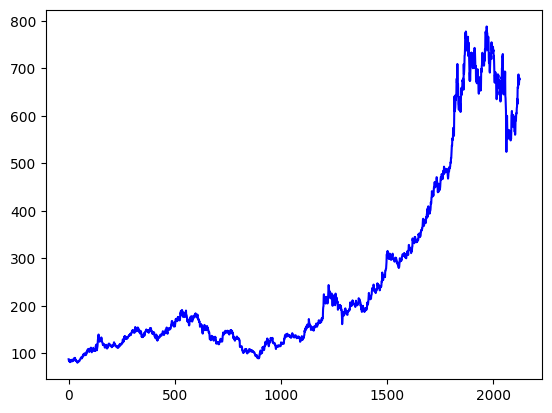

In [5]:
plt.plot(training_set,color='blue',label='Stock Price')

In [6]:
feature=['open','high','low','close','volume']

In [7]:
# MinMaxScaler: Normalization to 0-1
sc=MinMaxScaler(feature_range=(0,1))
training_set_scaler=sc.fit_transform(training_set) 
test_set_scaler=sc.transform(test_set)

In [8]:
training_set_scaler

array([[0.00961659],
       [0.0060261 ],
       [0.00528679],
       ...,
       [0.83672993],
       [0.84690772],
       [0.84309105]])

In [9]:
test_set_scaler

array([[0.8543997 ],
       [0.84167747],
       [0.86090218],
       [0.86524187],
       [0.91136703],
       [0.9009348 ],
       [0.92543217],
       [0.92813211],
       [0.91063197],
       [0.93214668],
       [0.91908519],
       [0.90670221],
       [0.90422845],
       [0.91237067],
       [0.93544032],
       [0.91426487],
       [0.93313619],
       [0.95336454],
       [1.00183624],
       [0.9913192 ],
       [0.98837895],
       [0.97172696],
       [0.94430348],
       [0.92861273],
       [0.95835448],
       [0.93922872],
       [0.95193682],
       [0.98586277],
       [0.98487327],
       [1.0312246 ],
       [1.0065152 ],
       [1.00678378],
       [0.99681803],
       [1.00848007],
       [0.98247018],
       [0.97879487],
       [1.00070538],
       [1.02657392],
       [1.09328082],
       [1.10036287],
       [1.08764063],
       [1.07986594],
       [1.10884435],
       [1.15860242],
       [1.16538761],
       [1.22615748],
       [1.19394196],
       [1.178

In [10]:
x_train,y_train,x_test,y_test=[],[],[],[]  # Create empty list
for i in range(60,len(training_set_scaler)):
    x_train.append(training_set_scaler[i-60:i,0])
    y_train.append(training_set_scaler[i,0])
    pass

# Convert the list to array format for train set

np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
np.random.seed(7)

x_train,y_train=np.array(x_train),np.array(y_train)

x_train=np.reshape(x_train,(x_train.shape[0],60,1))

In [11]:
# convert the list to array format for test set
for i in range(60,len(test_set_scaler)):
    x_test.append(test_set_scaler[i-60:i,0])
    y_test.append(test_set_scaler[i,0])
    pass

x_test,y_test=np.array(x_test),np.array(y_test)

x_test=np.reshape(x_test,(x_test.shape[0],60,1))

In [12]:
# Create LSTM model
lstm = Sequential()
lstm.add(LSTM(100, return_sequences=True, input_shape=(60, 1),
               kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
               bias_regularizer=l1_l2(l1=1e-4, l2=1e-3)))
lstm.add(Dropout(0.2))
lstm.add(LSTM(50, return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(50))
lstm.add(Dropout(0.2))
lstm.add(Dense(1))
early_stopping = EarlyStopping(monitor='val_loss', patience=10)


In [13]:
# Create GRU model
sequence_length = 60
batch_size = 32
epochs = 100
num_units = 128
dropout_rate = 0.2

gru = Sequential()
gru.add(GRU(num_units, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
gru.add(Dropout(dropout_rate))
gru.add(Dense(units=1))
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [14]:
# Compile model
lstm.compile(optimizer='adam',# Optimizer
              loss='mean_squared_error') # Loss function
gru.compile(optimizer='adam',# Optimizer
            loss='mean_squared_error') # Loss function

In [15]:
# Train lstm model
history_lstm = lstm.fit(x_train, y_train, epochs=100, batch_size=32, 
          validation_data=(x_train, y_train), callbacks=[early_stopping])
lstm.summary() # Print model structure

Epoch 1/100
65/65 [==============================] - 9s 66ms/step - loss: 0.1158 - val_loss: 0.0995
Epoch 2/100
65/65 [==============================] - 4s 54ms/step - loss: 0.0958 - val_loss: 0.0895
Epoch 3/100
65/65 [==============================] - 4s 56ms/step - loss: 0.0845 - val_loss: 0.0776
Epoch 4/100
65/65 [==============================] - 4s 58ms/step - loss: 0.0738 - val_loss: 0.0676
Epoch 5/100
65/65 [==============================] - 3s 53ms/step - loss: 0.0647 - val_loss: 0.0590
Epoch 6/100
65/65 [==============================] - 3s 51ms/step - loss: 0.0560 - val_loss: 0.0512
Epoch 7/100
65/65 [==============================] - 4s 57ms/step - loss: 0.0488 - val_loss: 0.0451
Epoch 8/100
65/65 [==============================] - 4s 62ms/step - loss: 0.0422 - val_loss: 0.0376
Epoch 9/100
65/65 [==============================] - 4s 56ms/step - loss: 0.0362 - val_loss: 0.0326
Epoch 10/100
65/65 [==============================] - 3s 52ms/step - loss: 0.0308 - val_loss: 0.0273

In [16]:
# Train gru model
history_gru = gru.fit(x_train, y_train, epochs=100, batch_size=32, 
          validation_data=(x_train, y_train), callbacks=[early_stopping])
gru.summary() # Print model structure

Epoch 1/100
65/65 [==============================] - 4s 37ms/step - loss: 0.0077 - val_loss: 2.1993e-04
Epoch 2/100
65/65 [==============================] - 2s 38ms/step - loss: 6.9278e-04 - val_loss: 2.3755e-04
Epoch 3/100
65/65 [==============================] - 2s 35ms/step - loss: 7.2082e-04 - val_loss: 2.6918e-04
Epoch 4/100
65/65 [==============================] - 2s 32ms/step - loss: 6.8909e-04 - val_loss: 1.5583e-04
Epoch 5/100
65/65 [==============================] - 2s 37ms/step - loss: 5.9240e-04 - val_loss: 1.7453e-04
Epoch 6/100
65/65 [==============================] - 2s 32ms/step - loss: 5.7292e-04 - val_loss: 3.2183e-04
Epoch 7/100
65/65 [==============================] - 2s 35ms/step - loss: 5.3297e-04 - val_loss: 1.5293e-04
Epoch 8/100
65/65 [==============================] - 2s 34ms/step - loss: 5.7844e-04 - val_loss: 1.4767e-04
Epoch 9/100
65/65 [==============================] - 2s 31ms/step - loss: 5.2964e-04 - val_loss: 1.9793e-04
Epoch 10/100
65/65 [============

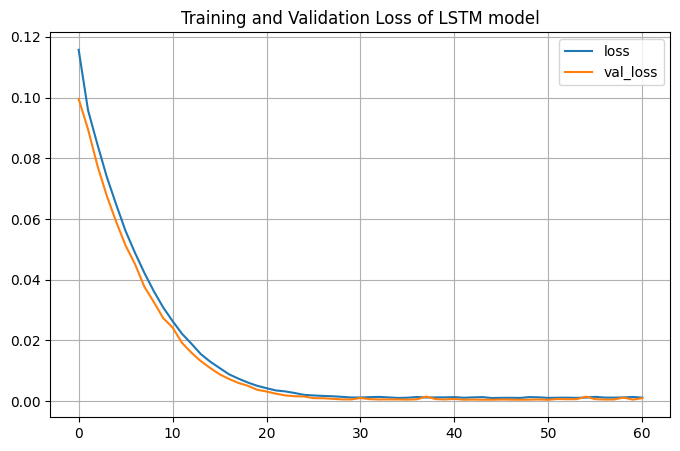

In [17]:
# Draw the loss curve of LSTM model
data={}
data['loss']=history_lstm.history['loss']

data['val_loss']=history_lstm.history['val_loss']
pd.DataFrame(data).plot(figsize=(8,5))
plt.grid(True)
plt.title('Training and Validation Loss of LSTM model')
plt.legend()
plt.show()

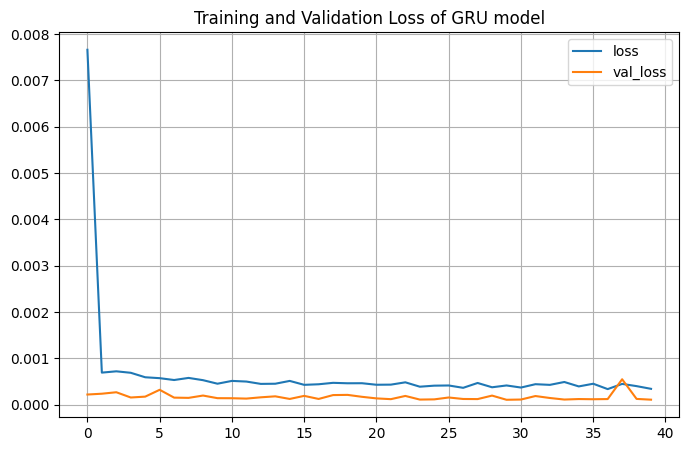

In [18]:
# Draw the loss curve of GRU model
data={}
data['loss']=history_gru.history['loss']

data['val_loss']=history_gru.history['val_loss']
pd.DataFrame(data).plot(figsize=(8,5))
plt.grid(True)
plt.title('Training and Validation Loss of GRU model')
plt.legend()
plt.show()

8/8 [==============================] - 1s 13ms/step


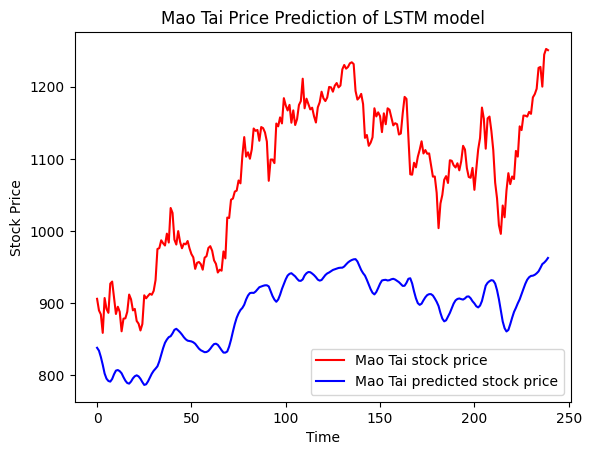

In [19]:
# Predict stock price of test set by LSTM model 
predicted_stock_price_lstm=lstm.predict(x_test)
# Inverse normalization to get the real stock price 
predicted_stock_price_lstm=sc.inverse_transform(predicted_stock_price_lstm)
predicted_stock_price_lstm

# Get the real stock price of test set
real_stock_price=sc.inverse_transform(test_set_scaler[60:])
real_stock_price
# Calculate the RMSE value

plt.plot(real_stock_price,color='red',label='Mao Tai stock price') #Truth value is red line

plt.plot(predicted_stock_price_lstm,color='blue',label='Mao Tai predicted stock price') #Predicted value is blue line

plt.title('Mao Tai Price Prediction of LSTM model')

plt.xlabel('Time')

plt.ylabel('Stock Price')

plt.legend()
plt.show()

8/8 [==============================] - 0s 8ms/step


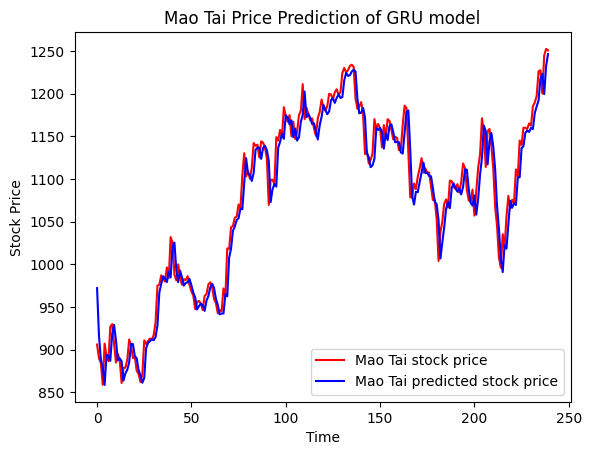

In [23]:
# Predict stock price of test set by GRU model 
predicted_stock_price_gru=gru.predict(x_test)
# Inverse normalization to get the real stock price 
predicted_stock_price_gru=sc.inverse_transform(predicted_stock_price_gru)
predicted_stock_price_gru

# Get the real stock price of test set
real_stock_price=sc.inverse_transform(test_set_scaler[60:])
real_stock_price
# Calculate the RMSE value

plt.plot(real_stock_price,color='red',label='Mao Tai stock price') #Truth value is red line

plt.plot(predicted_stock_price_gru,color='blue',label='Mao Tai predicted stock price') #Predicted value is blue line

plt.title('Mao Tai Price Prediction of GRU model')

plt.xlabel('Time')

plt.ylabel('Stock Price')

plt.legend()
plt.show()

In [24]:
# Calculate the RMSE value of LSTM model
mse_lstm=mean_squared_error(predicted_stock_price_lstm,real_stock_price)
rmse_lstm=math.sqrt(mse_lstm)

# Calculate the RMSE value of GRU model
mse_gru=mean_squared_error(predicted_stock_price_gru,real_stock_price)
rmse_gru=math.sqrt(mse_gru)

print('LSTM accury:')
print('MSE :%.6f'%mse_lstm)
print('RMSE :%.6f'%rmse_lstm)
print('GRU accury:')
print('MSE :%.6f'%mse_gru)
print('RMSE :%.6f'%rmse_gru)

LSTM accury:
MSE :37847.106796
RMSE :194.543329
GRU accury:
MSE :437.581220
RMSE :20.918442


# Conclusion
We found that GRU model has a lower RMSE value than LSTM model. It means that GRU model is more accurate than LSTM model for stock price prediction.